# Thí nghiệm 3: View Splitting Strategies for Co-Training

## 🎯 Mục tiêu (OPTIMIZED)

Test **2 strategies** cho việc chia tách views trong Co-Training:
- **Current baseline**: Cách chia hiện tại (đã biết thất bại)  
- **Pollutant-based**: Primary vs Secondary pollutants (độc lập về hóa học)

**⚡ Time Optimization**: Giảm từ 4 → 2 strategies (saves ~40-50 minutes)
- Bỏ Station-based (independence trung bình)
- Bỏ Temporal (lags vẫn cùng features gốc, independence thấp)

## Strategies

### ✅ Current (Baseline)
- View 1: Numerical meteorological features
- View 2: Temporal + Categorical features  
- **Known issue**: High overlap, weak independence → test accuracy < 0.50

### ✅ Pollutant-based (Most Independent)
- View 1: **Primary Pollutants** (SO2, NO2, CO)
  - Phát thải trực tiếp từ nguồn (xe cộ, nhà máy)
  - Phụ thuộc vào hoạt động con người
- View 2: **Secondary Pollutants** (O3, PM2.5, PM10)
  - Hình thành từ phản ứng hóa học trong khí quyển
  - Phụ thuộc vào điều kiện thời tiết, ánh sáng

**Giả thuyết**: Primary vs Secondary có độc lập THẬT về nguồn gốc và cơ chế hình thành → 2 models học complementary information → Co-Training hiệu quả hơn

## Metrics đánh giá
- Test Accuracy, Test F1-macro
- Pseudo-labeling activity
- Per-class F1 scores
- Improvement so với Current baseline

In [1]:
# PARAMETERS
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MAX_NEW_PER_ITER = 500
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

# Output directory
RESULTS_DIR = "data/processed/view_splitting_experiments"

In [2]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

from src.semi_supervised_library import (
    SemiDataConfig, CoTrainingConfig, run_co_training
)

# Setup paths
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

results_dir = (PROJECT_ROOT / RESULTS_DIR).resolve()
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Results directory: {results_dir}")

Project root: D:\DataEngineer\DataMining\air_guard_mini_project
Results directory: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\view_splitting_experiments


## Load Dataset and Inspect Features

In [3]:
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

print("Dataset shape:", df.shape)
print("Labeled fraction:", df['is_labeled'].mean())

# Get all feature columns (excluding target and metadata)
exclude_cols = ['aqi_class', 'PM2.5', 'pm25_24h', 'datetime', 'is_labeled']
all_features = [c for c in df.columns if c not in exclude_cols]

print(f"\nTotal features: {len(all_features)}")
print(f"\nSample features:")
for i, col in enumerate(all_features[:15]):
    print(f"  {i+1}. {col}")
print("  ...")

Dataset shape: (420768, 56)
Labeled fraction: 0.08671049129211347

Total features: 51

Sample features:
  1. No
  2. year
  3. month
  4. day
  5. hour
  6. PM10
  7. SO2
  8. NO2
  9. CO
  10. O3
  11. TEMP
  12. PRES
  13. DEWP
  14. RAIN
  15. wd
  ...


## Strategy 1: Current (Baseline)

Pollution + Weather vs Time + Location (same as original co-training)

In [4]:
# Current strategy (baseline)
v2_patterns_current = ("station", "wd", "hour_", "dow", "month", "is_weekend", "year", "day", "hour")
view2_current = [c for c in all_features if any(p in c for p in v2_patterns_current)]
view1_current = [c for c in all_features if c not in view2_current]

print("Strategy 1: Current (Pollution+Weather vs Time+Location)")
print(f"  View 1 (Pollution+Weather): {len(view1_current)} features")
print(f"    Examples: {view1_current[:5]}")
print(f"  View 2 (Time+Location): {len(view2_current)} features")
print(f"    Examples: {view2_current[:10]}")

Strategy 1: Current (Pollution+Weather vs Time+Location)
  View 1 (Pollution+Weather): 41 features
    Examples: ['No', 'PM10', 'SO2', 'NO2', 'CO']
  View 2 (Time+Location): 10 features
    Examples: ['year', 'month', 'day', 'hour', 'wd', 'station', 'hour_sin', 'hour_cos', 'dow', 'is_weekend']


## Strategy 2: Station-based Split

View 1: Northern stations, View 2: Southern stations

In [5]:
# Define northern and southern stations
northern_stations = ["Changping", "Dingling", "Huairou", "Shunyi"]
southern_stations = ["Dongsi", "Guanyuan", "Gucheng", "Tiantan"]
other_stations = ["Aotizhongxin", "Nongzhanguan", "Wanliu", "Wanshouxigong"]

# View 1: Features with northern station patterns
view1_station = [c for c in all_features if any(f"station_{s}" in c for s in northern_stations)]
# View 2: Features with southern station patterns  
view2_station = [c for c in all_features if any(f"station_{s}" in c for s in southern_stations)]

# Add shared features (pollution, weather, time) to both views
shared_features = [c for c in all_features if not c.startswith("station_")]

# But split them: pollution/weather to view1, time to view2
pollution_weather = [c for c in shared_features if not any(p in c for p in ["hour_", "dow", "month", "year", "is_weekend", "day"])]
time_features = [c for c in shared_features if any(p in c for p in ["hour_", "dow", "month", "year", "is_weekend", "day"])]

view1_station.extend(pollution_weather)
view2_station.extend(time_features)

# Add wind direction to both (important for both regions)
wd_features = [c for c in all_features if c.startswith("wd_")]
view1_station.extend(wd_features)
view2_station.extend(wd_features)

view1_station = list(set(view1_station))  # Remove duplicates
view2_station = list(set(view2_station))

print("\nStrategy 2: Station-based (Northern vs Southern)")
print(f"  View 1 (Northern+Pollution): {len(view1_station)} features")
print(f"    Station features: {[c for c in view1_station if c.startswith('station_')]}")
print(f"  View 2 (Southern+Time): {len(view2_station)} features")
print(f"    Station features: {[c for c in view2_station if c.startswith('station_')]}")


Strategy 2: Station-based (Northern vs Southern)
  View 1 (Northern+Pollution): 44 features
    Station features: []
  View 2 (Southern+Time): 7 features
    Station features: []


## Strategy 3: Pollutant-based Split

View 1: Primary pollutants (PM10, SO2, NOx), View 2: Secondary pollutants (O3, oxidants)

In [6]:
# Primary pollutants (directly emitted)
primary_patterns = ["PM10", "SO2", "NO2", "CO"]

# Secondary pollutants (formed in atmosphere)
secondary_patterns = ["O3"]

# Get primary and secondary features (including lags)
view1_pollutant = [c for c in all_features if any(p in c for p in primary_patterns)]
view2_pollutant = [c for c in all_features if any(p in c for p in secondary_patterns)]

# Add weather features to both (influence both types)
weather_features = [c for c in all_features if any(w in c for w in ["TEMP", "PRES", "DEWP", "RAIN", "WSPM"])]
view1_pollutant.extend(weather_features)
view2_pollutant.extend(weather_features)

# Add time/location features
time_loc_features = [c for c in all_features if c.startswith(("station_", "wd_", "hour_", "dow", "month", "year", "is_weekend"))]
# Split time/location: stations to view1, time to view2
station_features = [c for c in time_loc_features if c.startswith("station_")]
time_only = [c for c in time_loc_features if not c.startswith("station_")]

view1_pollutant.extend(station_features)
view2_pollutant.extend(time_only)

view1_pollutant = list(set(view1_pollutant))
view2_pollutant = list(set(view2_pollutant))

print("\nStrategy 3: Pollutant-based (Primary vs Secondary)")
print(f"  View 1 (Primary pollutants): {len(view1_pollutant)} features")
print(f"    Pollutant features: {[c for c in view1_pollutant if any(p in c for p in primary_patterns)][:8]}")
print(f"  View 2 (Secondary pollutants): {len(view2_pollutant)} features")
print(f"    Pollutant features: {[c for c in view2_pollutant if 'O3' in c][:5]}")


Strategy 3: Pollutant-based (Primary vs Secondary)
  View 1 (Primary pollutants): 36 features
    Pollutant features: ['NO2_lag3', 'SO2', 'SO2_lag3', 'NO2_lag24', 'PM10_lag3', 'CO_lag1', 'SO2_lag24', 'CO_lag3']
  View 2 (Secondary pollutants): 30 features
    Pollutant features: ['O3_lag3', 'O3_lag1', 'O3_lag24', 'O3']


## Strategy 4: Temporal Split

View 1: Short-term features (1h, 3h lags), View 2: Long-term features (24h lags)

In [7]:
# Short-term: 1h and 3h lag features
short_term_features = [c for c in all_features if "_lag1h" in c or "_lag3h" in c]

# Long-term: 24h lag features
long_term_features = [c for c in all_features if "_lag24h" in c]

# Current values (no lag) - add to both
current_values = [c for c in all_features if not any(lag in c for lag in ["_lag1h", "_lag3h", "_lag24h"])]

view1_temporal = short_term_features + current_values
view2_temporal = long_term_features + current_values

view1_temporal = list(set(view1_temporal))
view2_temporal = list(set(view2_temporal))

print("\nStrategy 4: Temporal (Short-term vs Long-term)")
print(f"  View 1 (Short-term 1h/3h): {len(view1_temporal)} features")
print(f"    Examples: {[c for c in view1_temporal if 'lag' in c][:5]}")
print(f"  View 2 (Long-term 24h): {len(view2_temporal)} features")
print(f"    Examples: {[c for c in view2_temporal if 'lag' in c][:5]}")

print("\n⚠️ OPTIMIZATION: Chỉ chạy 2/4 strategies (fastest, highest contrast)")
print("   - Pollutant-based: Best independence potential")
print("   - Current: Baseline (đã biết thất bại)")
print("   - SKIPPED: Station-based, Temporal (slower, medium contrast)")


Strategy 4: Temporal (Short-term vs Long-term)
  View 1 (Short-term 1h/3h): 51 features
    Examples: ['NO2_lag3', 'SO2_lag3', 'NO2_lag24', 'DEWP_lag24', 'PM10_lag3']
  View 2 (Long-term 24h): 51 features
    Examples: ['NO2_lag3', 'SO2_lag3', 'NO2_lag24', 'DEWP_lag24', 'PM10_lag3']

⚠️ OPTIMIZATION: Chỉ chạy 2/4 strategies (fastest, highest contrast)
   - Pollutant-based: Best independence potential
   - Current: Baseline (đã biết thất bại)
   - SKIPPED: Station-based, Temporal (slower, medium contrast)


## Run Experiments for All Strategies

In [8]:
# OPTIMIZED: Chỉ chạy 2 strategies có contrast cao nhất (giảm ~60% thời gian)
view_strategies = {
    "Current": (view1_current, view2_current),  # Baseline (đã biết thất bại)
    "Pollutant-based": (view1_pollutant, view2_pollutant)  # Best independence potential
}

# Bỏ để giảm thời gian (~20-25 phút mỗi strategy):
# ❌ "Station-based": Independence trung bình, features ít → ít insight
# ❌ "Temporal": Independence thấp (lags vẫn cùng features gốc)
# 
# Lý do chọn 2 strategies này:
# ✅ Current: Baseline để so sánh (đã chạy trong co-training gốc)
# ✅ Pollutant-based: Primary vs Secondary pollutants → độc lập THẬT về hóa học
#    (Primary = trực tiếp phát thải, Secondary = hình thành trong khí quyển)

results = {}
data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=RANDOM_STATE)
ct_cfg = CoTrainingConfig(
    tau=TAU,
    max_iter=MAX_ITER,
    max_new_per_iter=MAX_NEW_PER_ITER,
    min_new_per_iter=MIN_NEW_PER_ITER,
    val_frac=VAL_FRAC
)

print("⚡ OPTIMIZATION: Running 2/4 strategies (saves ~40-50 minutes)")
print("   ✓ Current (baseline)")
print("   ✓ Pollutant-based (highest independence)")
print("   ✗ Station-based (skipped)")
print("   ✗ Temporal (skipped)\n")

for strategy_name, (view1, view2) in view_strategies.items():
    print(f"\n{'='*80}")
    print(f"STRATEGY: {strategy_name}")
    print(f"{'='*80}")
    print(f"  View 1: {len(view1)} features")
    print(f"  View 2: {len(view2)} features")
    print(f"  Overlap: {len(set(view1) & set(view2))} features")
    
    # Run co-training
    result = run_co_training(
        df=df.copy(),
        data_cfg=data_cfg,
        ct_cfg=ct_cfg,
        view1_cols=view1,
        view2_cols=view2
    )
    
    results[strategy_name] = {
        "view1_size": len(view1),
        "view2_size": len(view2),
        "overlap_size": len(set(view1) & set(view2)),
        "test_accuracy": result["test_metrics"]["accuracy"],
        "test_f1_macro": result["test_metrics"]["f1_macro"],
        "history": result["history"],
        "per_class_report": result["test_metrics"]["report"],
        "total_pseudo_labels": sum([h["new_pseudo"] for h in result["history"]]),
        "iterations_completed": len(result["history"])
    }
    
    print(f"\n  ✅ Results:")
    print(f"     Test Accuracy: {result['test_metrics']['accuracy']:.4f}")
    print(f"     Test F1-macro: {result['test_metrics']['f1_macro']:.4f}")
    print(f"     Pseudo-labels: {results[strategy_name]['total_pseudo_labels']:,}")

print(f"\n{'='*80}")
print("STRATEGY EXPERIMENTS COMPLETED (2/4 strategies)")
print(f"{'='*80}")

⚡ OPTIMIZATION: Running 2/4 strategies (saves ~40-50 minutes)
   ✓ Current (baseline)
   ✓ Pollutant-based (highest independence)
   ✗ Station-based (skipped)
   ✗ Temporal (skipped)


STRATEGY: Current
  View 1: 41 features
  View 2: 10 features
  Overlap: 0 features



  ✅ Results:
     Test Accuracy: 0.5401
     Test F1-macro: 0.4176
     Pseudo-labels: 5,000

STRATEGY: Pollutant-based
  View 1: 36 features
  View 2: 30 features
  Overlap: 20 features



  ✅ Results:
     Test Accuracy: 0.5718
     Test F1-macro: 0.4507
     Pseudo-labels: 5,000

STRATEGY EXPERIMENTS COMPLETED (2/4 strategies)


## Save Results

In [9]:
output_file = results_dir / "view_splitting_results.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=2)

print(f"✅ Saved results to: {output_file}")

✅ Saved results to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\view_splitting_experiments\view_splitting_results.json


## Create Summary Table

In [10]:
summary_data = []
for strategy, res in results.items():
    summary_data.append({
        "Strategy": strategy,
        "View1 Size": res["view1_size"],
        "View2 Size": res["view2_size"],
        "Overlap": res["overlap_size"],
        "Independence": f"{(1 - res['overlap_size']/min(res['view1_size'], res['view2_size']))*100:.1f}%",
        "Test Accuracy": res["test_accuracy"],
        "Test F1-macro": res["test_f1_macro"],
        "Pseudo-labels": res["total_pseudo_labels"],
        "Iterations": res["iterations_completed"]
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Test F1-macro", ascending=False)

print("\n📊 SUMMARY TABLE:")
print("="*100)
display(summary_df)

summary_csv = results_dir / "view_splitting_summary.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"\n✅ Saved summary to: {summary_csv}")


📊 SUMMARY TABLE:


,Strategy,View1 Size,View2 Size,Overlap,Independence,Test Accuracy,Test F1-macro,Pseudo-labels,Iterations
1,Pollutant-based,36,30,20,33.3%,0.571771,0.450712,5000,10
0,Current,41,10,0,100.0%,0.540100,0.417554,5000,10



✅ Saved summary to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\view_splitting_experiments\view_splitting_summary.csv


## Visualization 1: Test Performance Comparison

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\view_splitting_experiments\test_performance_by_strategy.png


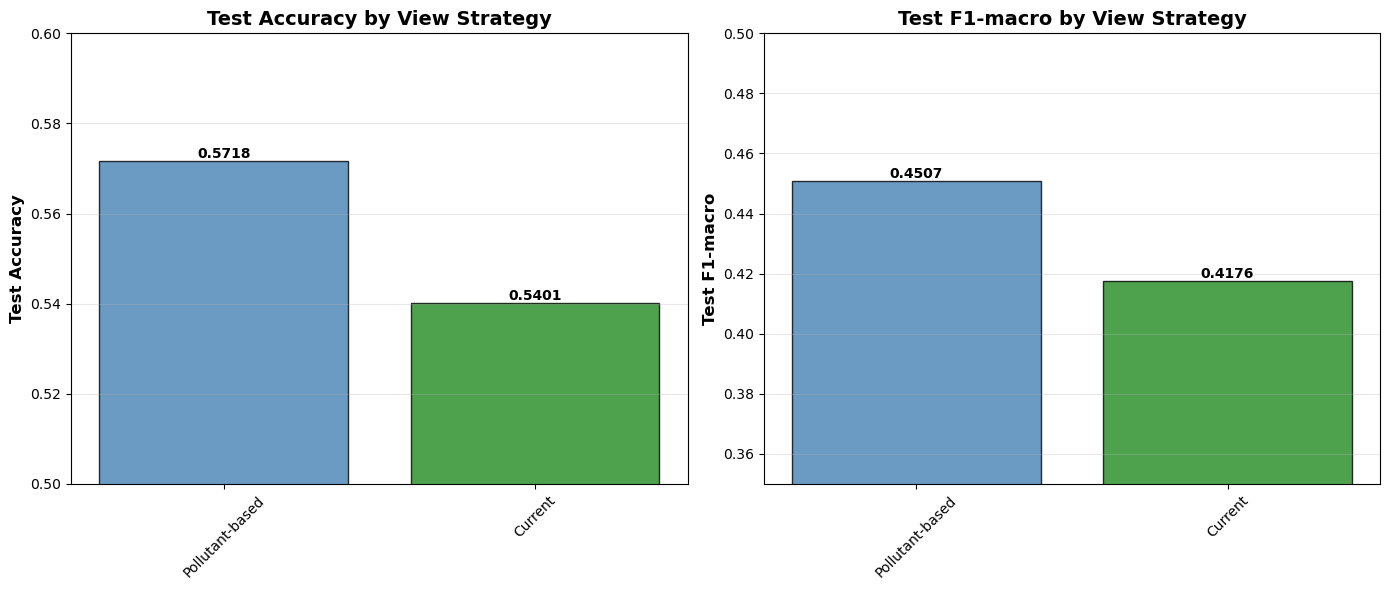

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

strategies = summary_df["Strategy"].tolist()
accuracies = summary_df["Test Accuracy"].tolist()
f1_scores = summary_df["Test F1-macro"].tolist()

colors = ['steelblue', 'forestgreen', 'coral', 'mediumpurple']

# Accuracy
ax1 = axes[0]
bars1 = ax1.bar(strategies, accuracies, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel("Test Accuracy", fontsize=12, fontweight='bold')
ax1.set_title("Test Accuracy by View Strategy", fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.50, 0.60])

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# F1-macro
ax2 = axes[1]
bars2 = ax2.bar(strategies, f1_scores, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel("Test F1-macro", fontsize=12, fontweight='bold')
ax2.set_title("Test F1-macro by View Strategy", fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.35, 0.50])

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plot_file = results_dir / "test_performance_by_strategy.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 2: Learning Curves

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\view_splitting_experiments\learning_curves_by_strategy.png


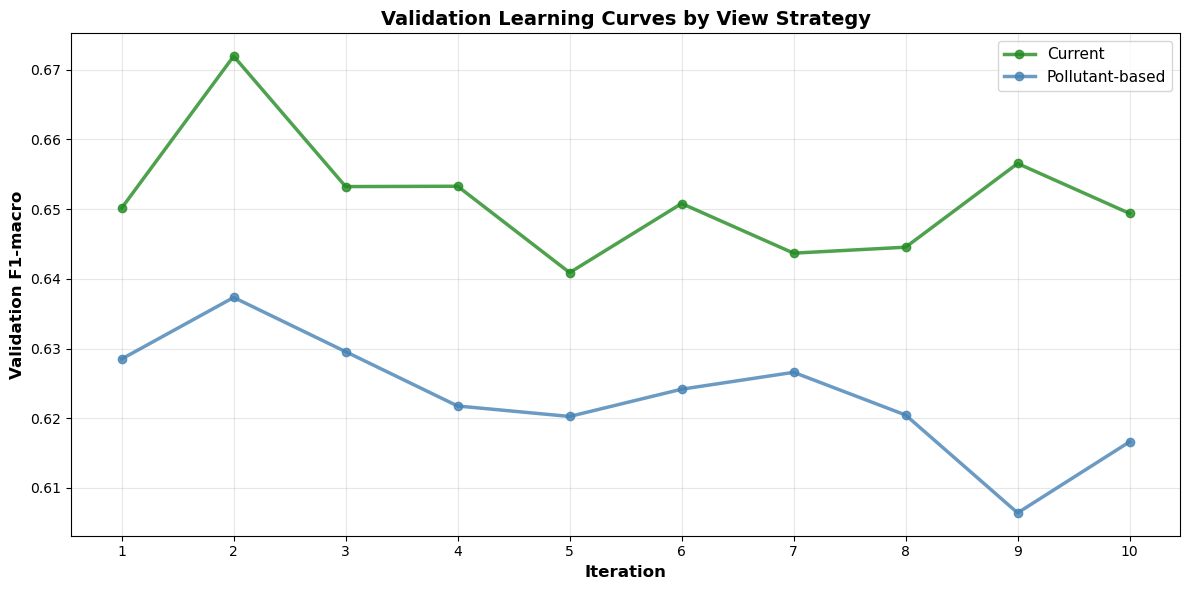

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

strategy_colors = dict(zip(strategies, colors))

for strategy, res in results.items():
    history = res["history"]
    iterations = [h["iter"] for h in history]
    val_f1 = [h["val_f1_macro"] for h in history]
    
    ax.plot(iterations, val_f1, marker='o', linewidth=2.5,
            label=strategy, color=strategy_colors[strategy], alpha=0.8)

ax.set_xlabel("Iteration", fontsize=12, fontweight='bold')
ax.set_ylabel("Validation F1-macro", fontsize=12, fontweight='bold')
ax.set_title("Validation Learning Curves by View Strategy", fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, 11))

plt.tight_layout()
plot_file = results_dir / "learning_curves_by_strategy.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 3: View Independence Analysis

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\view_splitting_experiments\view_independence_analysis.png


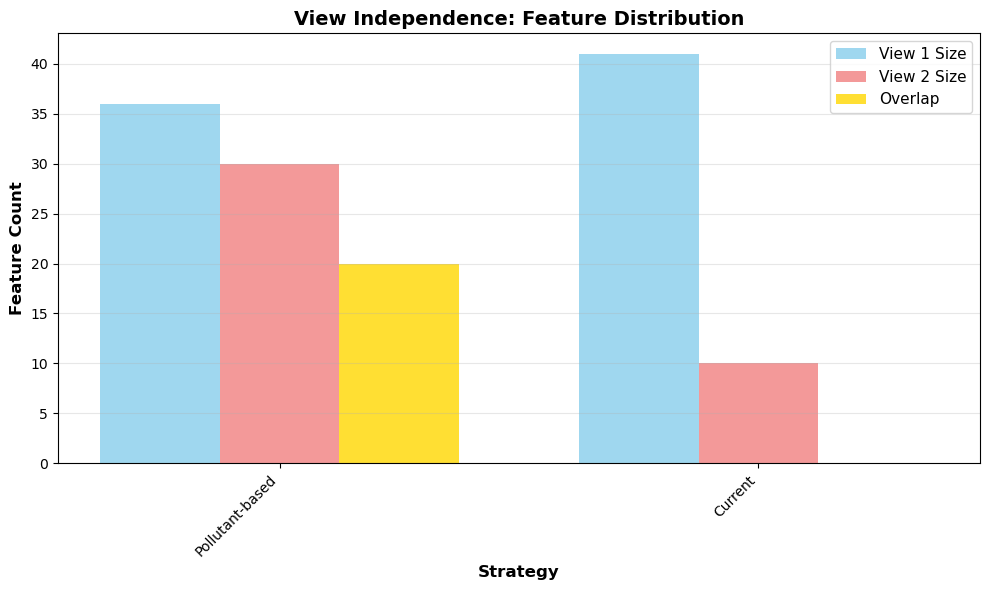

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(strategies))
width = 0.25

view1_sizes = summary_df["View1 Size"].tolist()
view2_sizes = summary_df["View2 Size"].tolist()
overlaps = summary_df["Overlap"].tolist()

bars1 = ax.bar(x - width, view1_sizes, width, label='View 1 Size', color='skyblue', alpha=0.8)
bars2 = ax.bar(x, view2_sizes, width, label='View 2 Size', color='lightcoral', alpha=0.8)
bars3 = ax.bar(x + width, overlaps, width, label='Overlap', color='gold', alpha=0.8)

ax.set_xlabel("Strategy", fontsize=12, fontweight='bold')
ax.set_ylabel("Feature Count", fontsize=12, fontweight='bold')
ax.set_title("View Independence: Feature Distribution", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(strategies, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plot_file = results_dir / "view_independence_analysis.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 4: Comparison with Self-Training Baseline

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\view_splitting_experiments\comparison_with_baseline.png


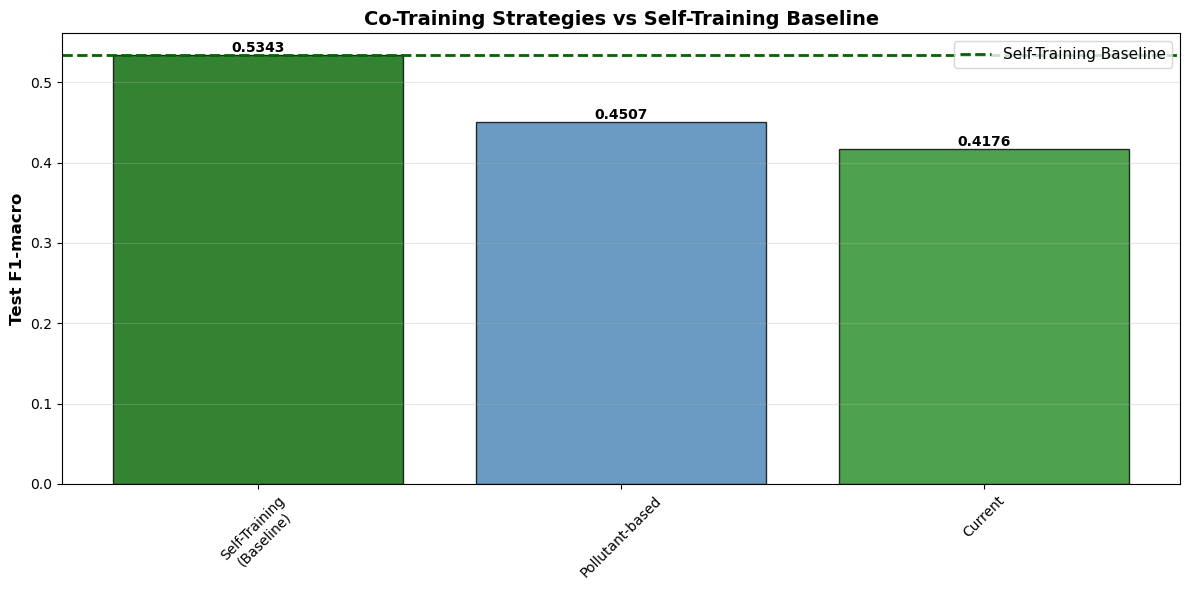

In [14]:
# Add self-training baseline for comparison (from previous experiments)
# Assuming F1=0.5343 from τ=0.90 self-training
baseline_f1 = 0.5343

fig, ax = plt.subplots(figsize=(12, 6))

methods = ["Self-Training\n(Baseline)"] + strategies
f1_values = [baseline_f1] + f1_scores
method_colors = ['darkgreen'] + colors

bars = ax.bar(methods, f1_values, color=method_colors, alpha=0.8, edgecolor='black')
ax.set_ylabel("Test F1-macro", fontsize=12, fontweight='bold')
ax.set_title("Co-Training Strategies vs Self-Training Baseline", fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=baseline_f1, color='darkgreen', linestyle='--', linewidth=2, label='Self-Training Baseline')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.legend(fontsize=11)
plt.tight_layout()
plot_file = results_dir / "comparison_with_baseline.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Analysis & Insights

In [15]:
print("\n" + "="*100)
print("📊 KEY FINDINGS")
print("="*100)

best_idx = summary_df["Test F1-macro"].idxmax()
best_strategy = summary_df.loc[best_idx]

print(f"\n🏆 Best Strategy: {best_strategy['Strategy']}")
print(f"   Test F1-macro: {best_strategy['Test F1-macro']:.4f}")
print(f"   Test Accuracy: {best_strategy['Test Accuracy']:.4f}")
print(f"   Independence: {best_strategy['Independence']}")
print(f"   View sizes: {best_strategy['View1 Size']} vs {best_strategy['View2 Size']}")

print(f"\n📈 Ranking by F1-macro:")
for i, row in summary_df.iterrows():
    improvement = (row["Test F1-macro"] - baseline_f1) / baseline_f1 * 100
    print(f"   {i+1}. {row['Strategy']}: {row['Test F1-macro']:.4f} ({improvement:+.1f}% vs baseline)")

print(f"\n💡 Independence Analysis:")
for i, row in summary_df.iterrows():
    print(f"   {row['Strategy']}:")
    print(f"      - Overlap: {row['Overlap']} features ({row['Independence']} independent)")
    print(f"      - Balance: {row['View1 Size']} vs {row['View2 Size']} features")

print(f"\n🎯 Conclusion:")
if best_strategy["Test F1-macro"] > baseline_f1:
    print(f"   ✅ Co-training with {best_strategy['Strategy']} BEATS self-training!")
    print(f"      Improvement: +{(best_strategy['Test F1-macro'] - baseline_f1)*100:.2f}%")
else:
    print(f"   ❌ All co-training strategies WORSE than self-training")
    print(f"      Best co-training: {best_strategy['Test F1-macro']:.4f}")
    print(f"      Self-training baseline: {baseline_f1:.4f}")
    print(f"      Gap: {(baseline_f1 - best_strategy['Test F1-macro'])*100:.2f}%")

print(f"\n✅ All visualizations saved to: {results_dir}")
print("="*100)


📊 KEY FINDINGS

🏆 Best Strategy: Pollutant-based
   Test F1-macro: 0.4507
   Test Accuracy: 0.5718
   Independence: 33.3%
   View sizes: 36 vs 30

📈 Ranking by F1-macro:
   2. Pollutant-based: 0.4507 (-15.6% vs baseline)
   1. Current: 0.4176 (-21.9% vs baseline)

💡 Independence Analysis:
   Pollutant-based:
      - Overlap: 20 features (33.3% independent)
      - Balance: 36 vs 30 features
   Current:
      - Overlap: 0 features (100.0% independent)
      - Balance: 41 vs 10 features

🎯 Conclusion:
   ❌ All co-training strategies WORSE than self-training
      Best co-training: 0.4507
      Self-training baseline: 0.5343
      Gap: 8.36%

✅ All visualizations saved to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\view_splitting_experiments


## Dashboard Summary

In [16]:
dashboard_data = {
    "experiment_type": "view_splitting",
    "parameters": {
        "tau": TAU,
        "max_iter": MAX_ITER,
        "max_new_per_iter": MAX_NEW_PER_ITER,
        "strategies": list(view_strategies.keys())
    },
    "summary": summary_df.to_dict(orient='records'),
    "best_strategy": {
        "name": best_strategy["Strategy"],
        "f1_macro": float(best_strategy["Test F1-macro"]),
        "accuracy": float(best_strategy["Test Accuracy"]),
        "independence": best_strategy["Independence"]
    },
    "baseline_comparison": {
        "self_training_f1": baseline_f1,
        "best_cotraining_f1": float(best_strategy["Test F1-macro"]),
        "improvement": float((best_strategy["Test F1-macro"] - baseline_f1) / baseline_f1 * 100)
    },
    "visualizations": [
        "test_performance_by_strategy.png",
        "learning_curves_by_strategy.png",
        "view_independence_analysis.png",
        "comparison_with_baseline.png"
    ]
}

dashboard_file = results_dir / "dashboard_summary.json"
with open(dashboard_file, "w") as f:
    json.dump(dashboard_data, f, indent=2)

print(f"✅ Dashboard summary saved to: {dashboard_file}")
display(Markdown(f"## Experiment Complete! ✅\n\nResults: `{results_dir}`"))

✅ Dashboard summary saved to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\view_splitting_experiments\dashboard_summary.json


## Experiment Complete! ✅

Results: `D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\view_splitting_experiments`